## Simulating Radiances

This example covers the simualation of synthetic measurements using pyshdom. This is a simple and streamlined example.

In [14]:
#imports

import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py

### Make the RTE grid and medium microphysics.

This time we are going to include both cloud and rayleigh scatter. 
The fundamental thing that must be defined first is the `rte_grid`, which sets the domain size. We have an easy choice here from the medium but in the inverse problem this must be selected as the initial step.

In [15]:
cloud_scatterer = at3d.util.load_from_csv('/Users/khargenr/AT3D/at3d/data/synthetic_cloud_fields/jpl_les/rico32x37x26.txt',
                                           density='lwc',origin=(0.0,0.0))

#load atmosphere
atmosphere = xr.open_dataset('/Users/khargenr/AT3D/at3d/data/ancillary/AFGL_summer_mid_lat.nc')
#subset the atmosphere, choose only the bottom four km.
reduced_atmosphere = atmosphere.sel({'z': atmosphere.coords['z'].data[atmosphere.coords['z'].data <= 4.0]})
#merge the atmosphere and cloud z coordinates
merged_z_coordinate = at3d.grid.combine_z_coordinates([reduced_atmosphere,cloud_scatterer])

# define the property grid - which is equivalent to the base RTE grid
rte_grid = at3d.grid.make_grid(cloud_scatterer.x.diff('x')[0],cloud_scatterer.x.data.size,
                          cloud_scatterer.y.diff('y')[0],cloud_scatterer.y.data.size,
                          np.append(0,cloud_scatterer.z.data))
print(cloud_scatterer)


<xarray.Dataset>
Dimensions:  (x: 32, y: 37, z: 26)
Coordinates:
  * x        (x) float64 0.0 0.02 0.04 0.06 0.08 0.1 ... 0.54 0.56 0.58 0.6 0.62
  * y        (y) float64 0.0 0.02 0.04 0.06 0.08 0.1 ... 0.64 0.66 0.68 0.7 0.72
  * z        (z) float64 0.44 0.48 0.52 0.56 0.6 ... 1.28 1.32 1.36 1.4 1.44
Data variables:
    delx     float64 0.02
    dely     float64 0.02
    density  (x, y, z) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    reff     (x, y, z) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    density_name:  lwc
    file_name:     /Users/khargenr/AT3D/at3d/data/synthetic_cloud_fields/jpl_...


In [16]:
#finish defining microphysics because we can.

cloud_scatterer_on_rte_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer)

#We choose a gamma size distribution and therefore need to define a 'veff' variable.
size_distribution_function = at3d.size_distribution.gamma

cloud_scatterer_on_rte_grid['veff'] = (cloud_scatterer_on_rte_grid.reff.dims,
                                       np.full_like(cloud_scatterer_on_rte_grid.reff.data, fill_value=0.1))

### Define Sensors

This is based on AirMSPI - like measurements. 9 observations in an arc.

Two perspective cameras either ground-based or out of an aircraft window.

and eMAS observations - nadir multi-spectral measurements.

By default, the resolution arguments for the sensors are actually spacing between rays. The radiance calculation itself is still just a single idealized ray. To more accurately model a wide pixel field of view we can model several sub-pixel-rays in each pixel.

In [17]:
sensor_dict = at3d.containers.SensorsDict()

In [18]:
sensor_zenith_list = [0.0]#75.0,67.5,60.0,52,45.6,35,26.1,10.0]*2 + [0.0]
sensor_azimuth_list = [0.0]#90]*8 + [-90]*8 +[0.0]
wavelengths = [.660, 1.240, 1.640, 2.13]
for wavelength in wavelengths:
    for zenith,azimuth in zip(sensor_zenith_list,sensor_azimuth_list):
        sensor_dict.add_sensor('MSPI', 
                at3d.sensor.orthographic_projection(wavelength, cloud_scatterer,0.02,0.02, azimuth, zenith,
                                         altitude='TOA', stokes='I')
                              )

### get optical property generators

Note that we assume a monochromatic model here.

In [19]:
mie_mono_tables = OrderedDict()
for wavelength in wavelengths:
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )

In [20]:
optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    size_distribution_function,
    density_normalization='density',
    reff=np.linspace(.1,30.0,30),
    veff=np.linspace(0.03,0.2,9),
)
optical_properties = optical_property_generator(cloud_scatterer_on_rte_grid)

In [21]:
# one function to generate rayleigh scattering.
rayleigh_scattering = at3d.rayleigh.to_grid(wavelengths,atmosphere,rte_grid)

## Define Solvers

Define solvers last based on the sensor's spectral information.

In [22]:
# NB IF YOU REDEFINE THE SENSORS BUT KEEP THE SAME SET OF SOLVERS 
# THERE IS NO NEED TO REDEFINE THE SOLVERS YOU CAN SIMPLY RERUN
# THE CELL BELOW WITHOUT NEEDING TO RERUN THE RTE SOLUTION.

solvers_dict = at3d.containers.SolversDict()
# note we could set solver dependent surfaces / sources / numerical_config here
# just as we have got solver dependent optical properties.

for wavelength in sensor_dict.get_unique_solvers():
    medium = {
        'cloud': optical_properties[wavelength],
        'rayleigh':rayleigh_scattering[wavelength]
     }
    config = at3d.configuration.get_config()
    solvers_dict.add_solver(
        wavelength,
        at3d.solver.RTE(
            numerical_params=config,
            surface=at3d.surface.lambertian(0.0),
            source=at3d.source.solar(wavelength, 0.71,0.0), #45 deg
            medium=medium,
            num_stokes=1#sensor_dict.get_minimum_stokes()[wavelength],
        )                   
   )

In [23]:
%%time
# solve the 4 RTEs in parallel AND get the measurements.
sensor_dict.get_measurements(solvers_dict, n_jobs=4, verbose=True)

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.632  0.349E+00    31968    39.47  0.154   [Radiance 1.240 micron]
     1  -0.631  0.343E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     1  -0.638  0.320E+00    31968    39.47  0.154   [Radiance 1.640 micron]
     1  -0.636  0.268E+00    31968    39.47  0.154   [Radiance 2.130 micron]
     2  -1.275  0.356E+00    31968    39.47  0.154   [Radiance 1.240 micron]
     2  -1.187  0.332E+00    31968    39.47  0.154   [Radiance 1.640 micron]
     2  -1.063  0.287E+00    31968    39.47  0.154   [Radiance 2.130 micron]
     2  -1.276  0.347E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.531  0.348E+00    31968    39.47  0.154   [Radiance 1.240 micron]
     3  -1.

### Visualize the observations


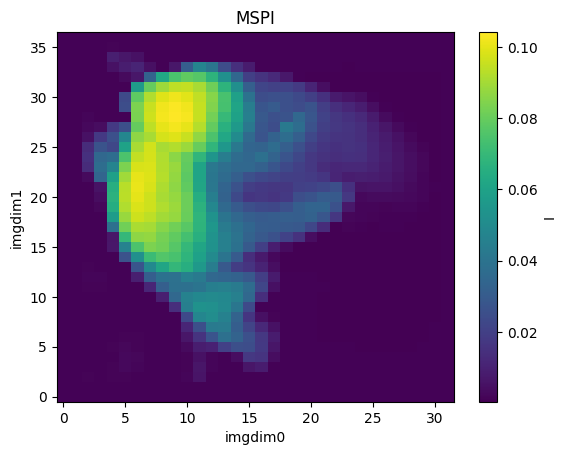

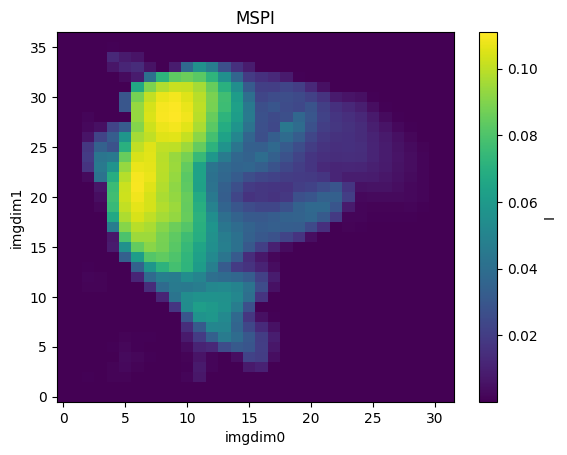

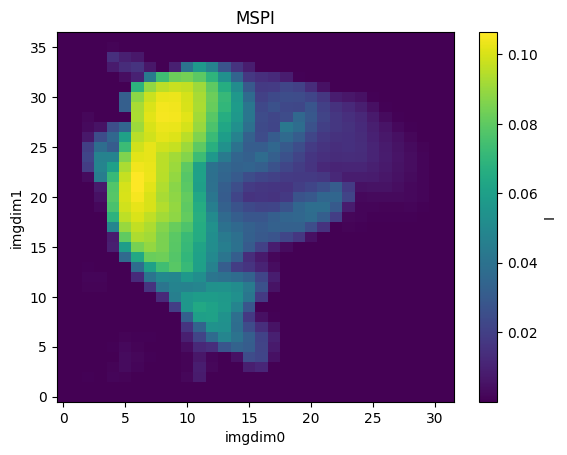

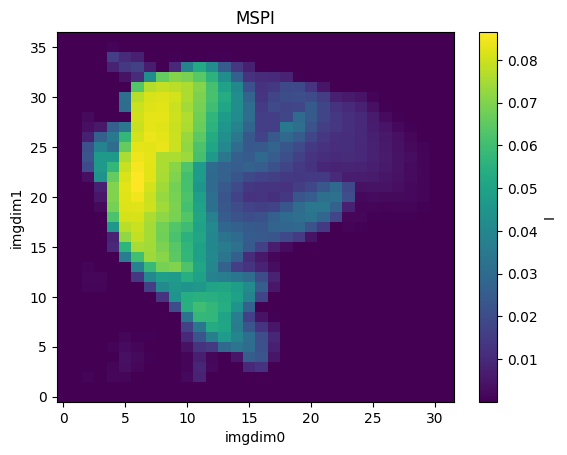

In [24]:
for instrument in sensor_dict:
    sensor_images = sensor_dict.get_images(instrument)
    for sensor in sensor_images:
        py.figure()
        sensor.I.T.plot()
        py.title(instrument)

In [25]:
# Save the model. This saves the inputs required to form the solver object
# and also the sensor_data. The radiative transfer solutions themselves are not saved by default
# as they are large.
# See solver.save_solution / solver.load_solution() for how to save & load those RTE solutions.
# Those functions are not yet integrated into util.save_forward_model / util.load_forward_model.
at3d.util.save_forward_model('SimulateRadiancesSmallRicoMultiSingle45DegreeSun.nc', sensor_dict, solvers_dict)

<xarray.Dataset>
Dimensions:        (x: 32, y: 37, z: 27, stokes_index: 6, legendre_index: 1311,
                    table_index: 22, num_micro: 1)
Coordinates:
    table_index    (num_micro, x, y, z) int64 1 1 1 1 1 2 ... 18 19 20 21 22 22
  * stokes_index   (stokes_index) object 'P11' 'P22' 'P33' 'P44' 'P12' 'P34'
  * x              (x) float64 0.0 0.02 0.04 0.06 0.08 ... 0.56 0.58 0.6 0.62
  * y              (y) float64 0.0 0.02 0.04 0.06 0.08 ... 0.66 0.68 0.7 0.72
  * z              (z) float64 0.0 0.44 0.48 0.52 0.56 ... 1.32 1.36 1.4 1.44
    reff           (x, y, z) float64 11.69 11.69 11.69 11.69 ... 18.57 18.7 18.7
    veff           (x, y, z) float64 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1
Dimensions without coordinates: legendre_index, num_micro
Data variables:
    extinction     (x, y, z) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ssalb          (x, y, z) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    legcoef        (stokes_index, legendre_index, 

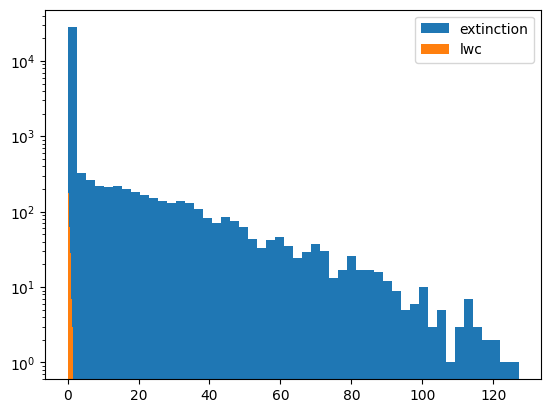

In [26]:
print(solvers_dict[.66].medium['cloud'])
py.hist(solvers_dict[.66].medium['cloud'].extinction.data.flatten(), bins=50, log=True, label="extinction")
py.hist(solvers_dict[.66].medium['cloud'].density.data.flatten(), bins=50, log=True, label='lwc')
py.legend()
py.show()